# Сравнение времени работы алгоритма поиска паросочетаний на взвешенном графе

В этой работе мы проведем тестирование работы алгоритма поиска паросочетаний, встроенных в библиотеку __networkx__, на примере случайных обычных графов и случайных двудольных графов с последовательно изменяющейся плотностью и числом вершин

## Импорт библиотек

In [1]:
! pip install networkx matplotlib numpy scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# imports
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.interpolate import CubicSpline
import random

# Пример работы алгоритмов

Для начала ознакомимся с тем, как работают алгоритмы maximum_matching и maximal_independent_set на графическом примере.

Случайный обычный граф:

{(15, 5), (0, 4), (9, 3), (8, 1), (7, 13), (10, 6), (2, 11), (12, 14)}
[(0, 4, {'weight': 9}), (0, 5, {'weight': 7}), (1, 4, {'weight': 4}), (1, 8, {'weight': 9}), (1, 10, {'weight': 1}), (1, 15, {'weight': 2}), (2, 4, {'weight': 1}), (2, 5, {'weight': 2}), (2, 11, {'weight': 1}), (2, 12, {'weight': 5}), (2, 15, {'weight': 4}), (3, 8, {'weight': 10}), (3, 9, {'weight': 10}), (3, 10, {'weight': 3}), (3, 15, {'weight': 9}), (4, 8, {'weight': 4}), (4, 12, {'weight': 6}), (4, 14, {'weight': 7}), (5, 6, {'weight': 8}), (5, 7, {'weight': 4}), (5, 9, {'weight': 3}), (5, 11, {'weight': 0}), (5, 12, {'weight': 0}), (5, 15, {'weight': 9}), (6, 7, {'weight': 1}), (6, 9, {'weight': 9}), (6, 10, {'weight': 5}), (6, 12, {'weight': 9}), (6, 13, {'weight': 0}), (6, 14, {'weight': 5}), (7, 9, {'weight': 6}), (7, 13, {'weight': 7}), (7, 15, {'weight': 1}), (8, 10, {'weight': 10}), (9, 12, {'weight': 8}), (9, 13, {'weight': 0}), (11, 14, {'weight': 0}), (12, 14, {'weight': 5}), (12, 15, {'weight': 6}), (

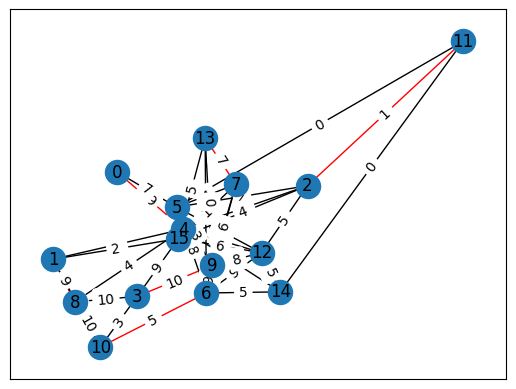

In [140]:
n = 4 * 4  # Число вершин
p = 0.3  # Плотность графа
G = nx.fast_gnp_random_graph(n, p)  # Создаем граф

for (u,v,w) in G.edges(data=True):
    w['weight'] = random.randint(0,10)

matchings = nx.max_weight_matching(G, maxcardinality=True)  # Вызываем алгоритм
print(matchings)

# Красим ребра, помеченные алгоритмом, в красный цвет
edge_color_list = ["black"]*len(G.edges)
for i, edge_set in enumerate(G.edges()):
    edge = list(edge_set)
    if (edge_set in matchings) or ((edge[1], edge[0]) in matchings):
        edge_color_list[i] = 'red'

labels = nx.get_edge_attributes(G,'weight')
pos = nx.spring_layout(G, seed=7)

# Отображаем граф
nx.draw_networkx(
    G,
    edge_color=edge_color_list,
    pos=pos
)

nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
print(G.edges(data=True))


Случайный двудольный граф:

{(4, 6), (7, 3), (5, 0), (8, 2), (1, 9)}
[(0, 7, {'weight': 1}), (0, 8, {'weight': 0}), (0, 5, {'weight': 10}), (1, 9, {'weight': 7}), (1, 7, {'weight': 10}), (2, 7, {'weight': 0}), (2, 5, {'weight': 3}), (2, 8, {'weight': 0}), (3, 7, {'weight': 10}), (3, 6, {'weight': 2}), (3, 9, {'weight': 2}), (4, 5, {'weight': 6}), (4, 7, {'weight': 5}), (4, 6, {'weight': 1}), (4, 8, {'weight': 2})]


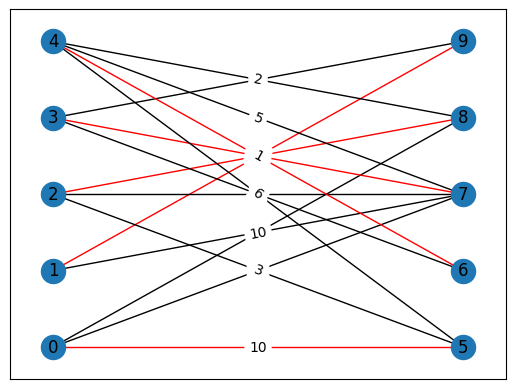

In [128]:
n = 5  # Число вершин одной доли
p = 0.6  # Плотность графа
B = bipartite.gnmk_random_graph(n, n, n * n * p)  # Создаем граф

for (u,v,w) in B.edges(data=True):
    w['weight'] = random.randint(0,10)

matchings = nx.max_weight_matching(B, maxcardinality=True)
print(matchings)

# Красим ребра, помеченные алгоритмом, в красный цвет
edge_color_list = ["black"]*len(B.edges)
for i, edge_set in enumerate(B.edges()):
    edge = list(edge_set)
    if (edge_set in matchings) or ((edge[1], edge[0]) in matchings):
        edge_color_list[i] = 'red'

# Отображаем граф
nx.draw_networkx(
    B,
    pos=nx.bipartite_layout(B, np.arange(0, n, 1)),
    edge_color=edge_color_list
)

labels = nx.get_edge_attributes(B,'weight')

nx.draw_networkx_edge_labels(B,pos=nx.bipartite_layout(B, np.arange(0, n, 1)),edge_labels=labels)
print(B.edges(data=True))


## Анализ алгоритма поиска паросочетаний

In [122]:
def test_regular_matching_density(n_vertices, density_array, max_iter):
    time_array = []
    edges_array = []

    G = 0

    for d in density_array:
        for _ in range(max_iter):
            G = nx.fast_gnp_random_graph(n_vertices, d)
            if (nx.is_connected(G)):
                break

        for (_,_,w) in G.edges(data=True):
            w['weight'] = random.randint(0,10)

        # Разогревочный пробег алгоритма
        nx.max_weight_matching(G, maxcardinality=True)
        start = time.perf_counter()  # Засекаем время
        nx.max_weight_matching(G, maxcardinality=True)  # и пытаемся вызвать алгоритм
        end = time.perf_counter()

        # Добавляем засеченное время в массив
        time_array.append(end - start)
        # Добавляем число вершин в массив
        edges_array.append(len(G.edges))

    return time_array, edges_array


In [123]:
# densities = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
densities = np.arange(0.3, 1, 0.025)
n_vertices = 2000
time_array, edges_array = test_regular_matching_density(
    n_vertices, densities, 100)


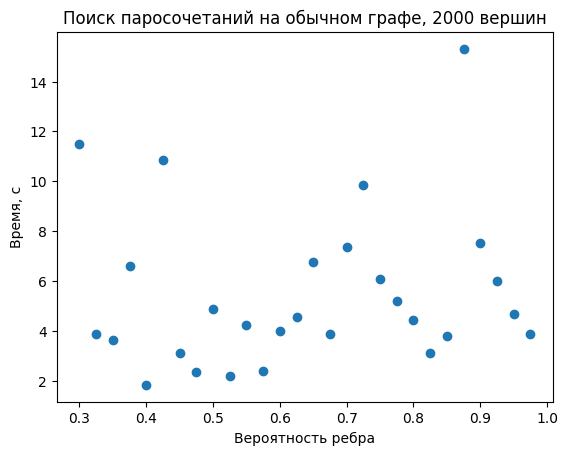

In [141]:
plt.title('Поиск паросочетаний на обычном графе, {} вершин'.format(n_vertices))
plt.xlabel('Вероятность ребра')
plt.ylabel('Время, с')
# plt.plot(densities, time_array, label="Результат")
plt.scatter(densities, time_array)

x = [densities[0], densities[3], densities[-1]]
y = [time_array[0], time_array[3], time_array[-1]]
cs = CubicSpline(x, y)

# plt.plot(densities, cs(densities), linestyle="dashed", label="Аппроксимация")
# plt.legend()
plt.show()


In [119]:
def test_regular_matching_vertices(vertices_array, density, max_iter):
    time_array = []
    edges_array = []

    G = 0

    for v in vertices_array:
        for _ in range(max_iter):
            G = nx.fast_gnp_random_graph(v, density)
            if (nx.is_connected(G)):
                break

        for (_,_,w) in G.edges(data=True):
            w['weight'] = random.randint(0,10)

        # Разогревочный пробег алгоритма
        nx.max_weight_matching(G, maxcardinality=True)
        start = time.perf_counter()  # Засекаем время
        nx.max_weight_matching(G, maxcardinality=True)  # и пытаемся вызвать алгоритм
        end = time.perf_counter()

        # Добавляем засеченное время в массив
        time_array.append(end - start)
        # Добавляем число вершин в массив
        edges_array.append(len(G.edges))

    return time_array, edges_array


In [13]:
density = 0.5
vertices_array = np.arange(100, 2001, 25)
time_array, edges_array = test_regular_matching_vertices(
    vertices_array, density, 100)


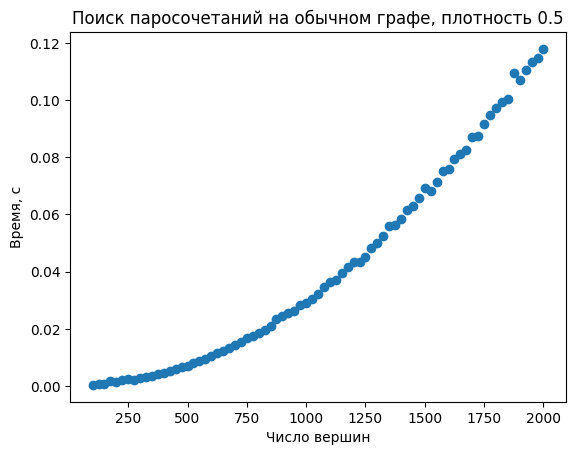

In [14]:
plt.title('Поиск паросочетаний на обычном графе, плотность {}'.format(density))
plt.xlabel('Число вершин')
plt.ylabel('Время, с')
# plt.plot(vertices_array, time_array, label="Результат")
plt.scatter(vertices_array, time_array)

x = [vertices_array[0], vertices_array[3], vertices_array[-1]]
y = [time_array[0], time_array[3], time_array[-1]]
cs = CubicSpline(x, y)

# plt.plot(vertices_array, cs(vertices_array),
#  linestyle="dashed", label="Аппроксимация")
# plt.legend()
plt.show()


In [15]:
def test_bipartite_matching_density(n_vertices, density_array, max_iter):
    time_array = []
    edges_array = []

    B = 0

    for d in density_array:
        for _ in range(max_iter):
            B = bipartite.gnmk_random_graph(
                n_vertices, n_vertices, n_vertices * n_vertices * d)
            if (nx.is_connected(B)):
                break

        for (_,_,w) in B.edges(data=True):
            w['weight'] = random.randint(0,10)

        # Разогревочный пробег алгоритма
        nx.max_weight_matching(B, maxcardinality=True)
        start = time.perf_counter()  # Засекаем время
        nx.max_weight_matching(B, maxcardinality=True)  # и пытаемся вызвать алгоритм
        end = time.perf_counter()

        # Добавляем засеченное время в массив
        time_array.append(end - start)
        # Добавляем число вершин в массив
        edges_array.append(len(B.edges))

    return time_array, edges_array


In [16]:
# densities = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
densities = np.arange(0.3, 1, 0.025)
n_vertices = 1000
time_array, edges_array = test_bipartite_matching_density(
    n_vertices, densities, 100)


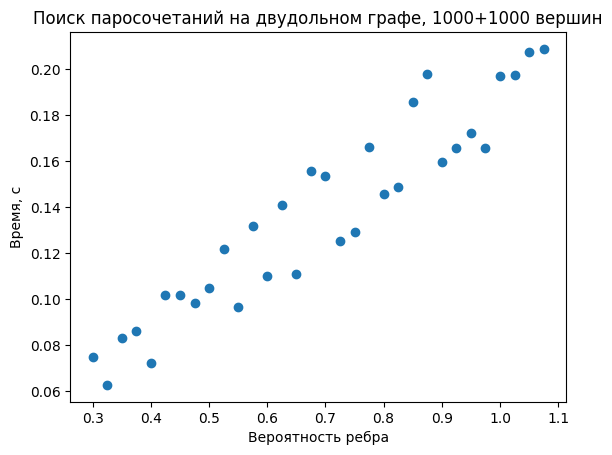

In [17]:
plt.title('Поиск паросочетаний на двудольном графе, {}+{} вершин'.format(n_vertices, n_vertices))
plt.xlabel('Вероятность ребра')
plt.ylabel('Время, с')
# plt.plot(densities, time_array, label="Результат")
plt.scatter(densities, time_array)

x = [densities[0], densities[3], densities[-1]]
y = [time_array[0], time_array[3], time_array[-1]]
cs = CubicSpline(x, y)

# plt.plot(densities, cs(densities), linestyle="dashed", label="Аппроксимация")
# plt.legend()
plt.show()


In [18]:
def test_bipartite_matching_vertices(vertices_array, density, max_iter):
    time_array = []
    edges_array = []

    B = 0

    for v in vertices_array:
        for _ in range(max_iter):
            B = bipartite.gnmk_random_graph(v, v, v * v * density)
            if (nx.is_connected(B)):
                break

        for (_,_,w) in B.edges(data=True):
            w['weight'] = random.randint(0,10)

        # Разогревочный пробег алгоритма
        nx.max_weight_matching(B, maxcardinality=True)
        start = time.perf_counter()  # Засекаем время
        nx.max_weight_matching(B, maxcardinality=True)  # и пытаемся вызвать алгоритм
        end = time.perf_counter()

        # Добавляем засеченное время в массив
        time_array.append(end - start)
        # Добавляем число вершин в массив
        edges_array.append(len(G.edges))

    return time_array, edges_array


In [19]:
density = 0.5
vertices_array = np.arange(100, 1001, 25)
time_array, edges_array = test_bipartite_matching_vertices(
    vertices_array, density, 100)


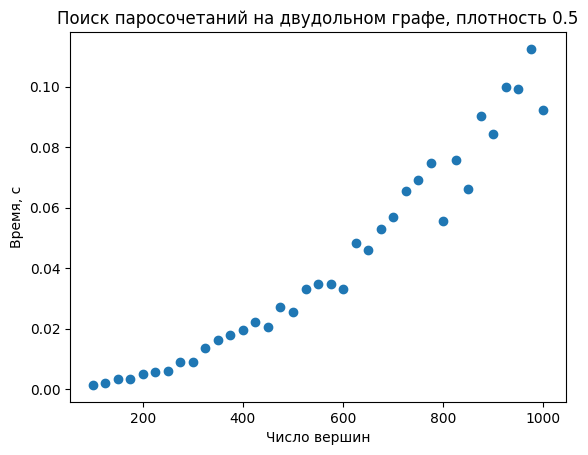

In [20]:
plt.title('Поиск паросочетаний на двудольном графе, плотность {}'.format(density))
plt.xlabel('Число вершин')
plt.ylabel('Время, с')
# plt.plot(vertices_array, time_array, label="Результат")
plt.scatter(vertices_array, time_array)

x = [vertices_array[0], vertices_array[3], vertices_array[-1]]
y = [time_array[0], time_array[3], time_array[-1]]
cs = CubicSpline(x, y)

# plt.plot(vertices_array, cs(vertices_array),
#  linestyle="dashed", label="Аппроксимация")
# plt.legend()
plt.show()
